In [51]:
from gurobipy import Model, GRB, quicksum
import pandas as pd
import numpy as np
import time
import math
import datetime
# import gurobipy as gp  # import the installed package

In [25]:
np.logspace(-3, 3, 20)

array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])

In [26]:
np.linspace(0, 1000000, 1000)

array([      0.        ,    1001.001001  ,    2002.002002  ,
          3003.003003  ,    4004.004004  ,    5005.00500501,
          6006.00600601,    7007.00700701,    8008.00800801,
          9009.00900901,   10010.01001001,   11011.01101101,
         12012.01201201,   13013.01301301,   14014.01401401,
         15015.01501502,   16016.01601602,   17017.01701702,
         18018.01801802,   19019.01901902,   20020.02002002,
         21021.02102102,   22022.02202202,   23023.02302302,
         24024.02402402,   25025.02502503,   26026.02602603,
         27027.02702703,   28028.02802803,   29029.02902903,
         30030.03003003,   31031.03103103,   32032.03203203,
         33033.03303303,   34034.03403403,   35035.03503504,
         36036.03603604,   37037.03703704,   38038.03803804,
         39039.03903904,   40040.04004004,   41041.04104104,
         42042.04204204,   43043.04304304,   44044.04404404,
         45045.04504505,   46046.04604605,   47047.04704705,
         48048.04804805,

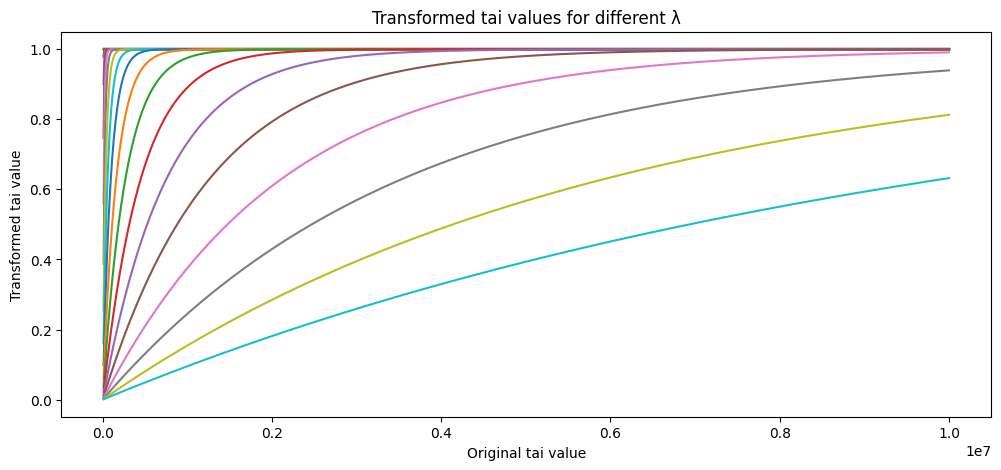

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
# 定义tai的范围
tai_values = np.linspace(10000, 10000000, 1000) 
# 定义不同的lambda值
lambda_values = np.logspace(-0.5, -7, 30)

# 为每个lambda绘制转换前后的tai值
for lambda_for_G in lambda_values:
    transformed_tai = 1 - np.exp(-lambda_for_G * tai_values)
    plt.plot(tai_values, transformed_tai, label=f'λ = {lambda_for_G}')
plt.title('Transformed tai values for different λ')
plt.xlabel('Original tai value')
plt.ylabel('Transformed tai value')
# plt.legend()
plt.show()

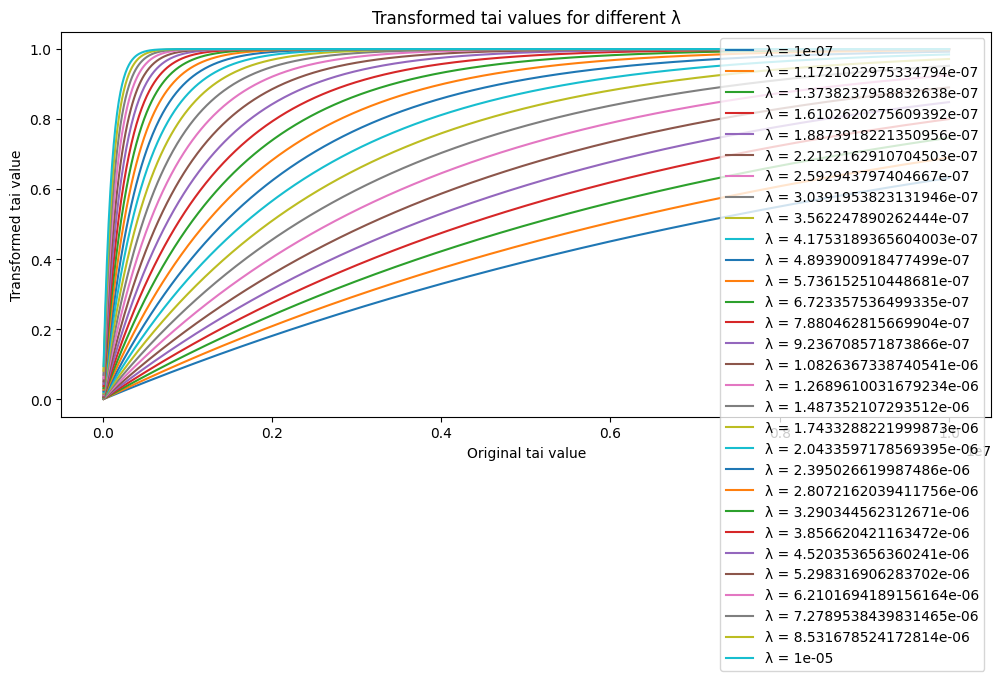

In [27]:
plt.figure(figsize=(12,5))
# 定义tai的范围
tai_values = np.linspace(10000, 10000000, 1000) 
# 定义不同的lambda值
lambda_values = np.logspace(-7, -5, 30)

# 为每个lambda绘制转换前后的tai值
for lambda_for_G in lambda_values:
    transformed_tai = 1 - np.exp(-lambda_for_G * tai_values)
    plt.plot(tai_values, transformed_tai, label=f'λ = {lambda_for_G}')
plt.title('Transformed tai values for different λ')
plt.xlabel('Original tai value')
plt.ylabel('Transformed tai value')
plt.legend()
plt.show()

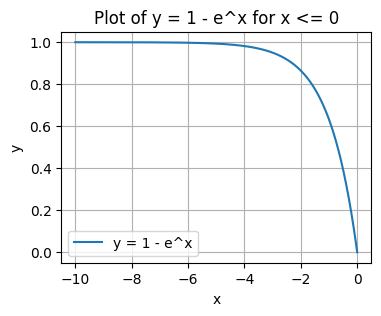

In [85]:
x = np.linspace(-10, 0, 1000)
# 1-e^x
y = 1 - np.exp(x)
# 绘图
plt.figure(figsize=(4, 3))
plt.plot(x, y, label='y = 1 - e^x')
plt.title('Plot of y = 1 - e^x for x <= 0')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
config = { #0312成功版本config
    'M': 1000000,
    'lambda_for_G': 0.000006,
    'i_amount' :1, #客戶
    'j_amount' :1, #設廠地點
    'k_amount' :1, #可分配資源（大車, 小車)
    'l_amount' :1, #對手數量
    'U_LT': [[3]],
    'U_T': [5],
    'U_L': [4],
    'V': [[1000]],
    'H': [100],
    'D': [[1]],
    'D_comp':[[1]],
    'A_opponent_bar': [1000], #對手吸引力
    'F': [0.1],
    'C': [0.001], 
    'B': [[0.1]],
}
I = set(range(0, config['i_amount']))  
J = set(range(0, config['j_amount']))  
K = set(range(0, config['k_amount']))  
L = set(range(0, config['l_amount']))  

In [131]:
# Initialize the model
model = Model("Competitive Facility Location")
model.setParam('NumericFocus', 3)
y = model.addVars(J, vtype=GRB.BINARY, name="y") #3.14
x = model.addVars(J, K, vtype=GRB.CONTINUOUS, name="x", lb=0) # 3.12
aX = model.addVars(J, vtype=GRB.CONTINUOUS, name="aX", lb=0) # 3.13

u = model.addVars(I, J, vtype=GRB.CONTINUOUS, name="utility(u)", lb=0) # utility var(3.5)
P = model.addVars(I, J, vtype=GRB.CONTINUOUS, name="P, utility vs TA ratio", lb=0.0, ub=1.0) # Probability of i choosing j
TA = model.addVars(I, vtype=GRB.CONTINUOUS, name="TA", lb=0.00000001)
TAi_lambda = model.addVars(I, vtype=GRB.CONTINUOUS, name="negative TAi*lambda(e's power)", lb= -5, ub= -0.001) #-lambda*TAi
G_exp_vars = model.addVars(I, vtype=GRB.CONTINUOUS, name="G_exp_vars", lb=0.001, ub=0.999) #e^-(lambda*TAi), ub=0.5

model.update()

model.addConstrs((x[j, k] <= config['U_LT'][j][k] * y[j] for j in J for k in K), "(3.1) Resource only for built facility, and amount of type k for facility j is limit at U_LT[j, k]")
model.addConstrs((quicksum(x[j, k] for j in J) <= config['U_T'][k] for k in K), "(3.2) The total amount of resource k is U_T[k]")
model.addConstrs((quicksum(x[j, k] for k in K) <= config['U_L'][j] for j in J), "(3.3) The max resource sum for facility j is U_L[j]")
model.addConstrs((aX[j] <= config['M'] * y[j] for j in J), "(3.4) Extra Attractiveness Limit")

model.addConstrs((u[i, j] == ((quicksum(config['V'][j][k] * x[j, k] for k in K) + aX[j]) / (config['D'][i][j]**2)) for i in I for j in J), "(3.5) utility for facility j to customer i")
model.addConstrs((u[i, j] == P[i, j] * TA[i] for i in I for j in J), "(3.8) calculate P by uij/TAi, 分母要是常數所以用乘的")
## TA的限制式, 因為不能讓 G_exp中 addGenConstrExp內的變數為多個變數的線性組合所以要另外創TA變數
model.addConstrs((TA[i] == quicksum(u[i, j] for j in J) + (quicksum(config['A_opponent_bar'][l] / (config['D_comp'][i][l]**2) for l in L)) for i in I), "(3.7) calculate total TA by u and A_bar")

## G的計算
# def G(tai):
#     return 1 - np.exp(-config['lambda_for_G'] * tai)
model.addConstrs((TAi_lambda[i] == (-config['lambda_for_G'] * TA[i]) for i in I), "negative tai*lambda constr")
# Gurobi無法直接在目標式有exponential
for i in I:
    model.addGenConstrExpA(TAi_lambda[i], G_exp_vars[i], math.e, name=f"G_exp_constr_{i}")



# Objective function: Maximize profit by attracting customers - costs
objective = ((quicksum(config['H'][i] * (1 - G_exp_vars[i]) * (quicksum(P[i, j] for j in J)) for i in I)) \
          - (quicksum(config['F'][j] * y[j] + config['C'][j] * aX[j] + quicksum(config['B'][j][k] * x[j, k] for k in K) for j in J)))
model.setObjective(objective, GRB.MAXIMIZE)


# Solve and Output
model.optimize()
if model.status == GRB.OPTIMAL:
    print("Optimal solution found.")
else:
    print("No optimal solution found.")
    model.computeIIS()
    # 将IIS输出到文件
    model.write("model_iis.mps")
    print("IIS written to file 'model_iis.mps'")


Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.5.0 21F79)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 8 columns and 13 nonzeros
Model fingerprint: 0x3aaeae19
Model has 1 quadratic objective term
Model has 1 quadratic constraint
Model has 1 general constraint
Variable types: 7 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-03, 1e+02]
  QObjective range [2e+02, 2e+02]
  Bounds range     [1e-08, 5e+00]
  RHS range        [4e+00, 1e+03]
Presolve added 1 rows and 22 columns
Presolve time: 0.00s
Presolved: 14 rows, 32 columns, 91 nonzeros
Presolved model has 1 SOS constraint(s)
Presolved model has 2 bilinear constraint(s)
         in product terms.
         Presolve was not able t

In [136]:
for var in model.getVars():
  print(f"{var.varName} = {var.x}")
  if var.VarName == "G_exp_vars[0]":
    print(f"市場點0之效用（介於0~1): {1-var.x}")
print("")

y[0] = 1.0
x[0,0] = 3.0
aX[0] = 0.00025736484897431744
utility(u)[0,0] = 3000.000257364849
P, utility vs TA ratio[0,0] = 0.7500000160853043
TA[0] = 4000.000257364849
negative TAi*lambda(e's power)[0] = -0.024000001544189093
G_exp_vars[0] = 0.9765562035657964
市場點0之效用（介於0~1): 0.02344379643420358



In [105]:
model.computeIIS()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.5.0 21F79)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


IIS computation: initial model status unknown, solving to determine model status
Presolve added 0 rows and 18 columns
Presolve removed 3 rows and 0 columns
Presolve time: 0.00s
Presolved: 8 rows, 27 columns, 57 nonzeros
Presolved model has 1 SOS constraint(s)
Presolved model has 1 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for these variables.
         Consider bounding these variables or reformulating the model.


Solving non-convex MIQCP

Variable types: 27 continuous, 0 integer (0 binary)
Found heuristic solution: objective -0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: -0 
No other solutions better than

GurobiError: Cannot compute IIS on a feasible model

# References

## G calculation substitude exponential

https://www.gurobi.com/documentation/10.0/refman/py_model_agc_exp.html

https://support.gurobi.com/hc/en-us/community/posts/360077178491-Build-an-objective-function-with-Log-and-Exponential-inside-

https://support.gurobi.com/hc/en-us/community/posts/10481250723217-How-to-add-log-and-exponential-term-in-objective-function
